In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

sns.set(style="whitegrid")


In [13]:
materials = pd.read_csv("data/processed/materials_final.csv")

print("Dataset loaded successfully")
display(materials.head())


Dataset loaded successfully


,material_id,material_name,strength_rating,weight_capacity_kg,biodegradability_score,recyclability_percent,co2_emission_score,cost_per_kg
0,1,Paperboard,7,5.0,85,90,1.2,45
1,2,Corrugated Cardboard,9,15.0,70,80,1.6,55
2,3,Bagasse (Sugarcane Fiber),6,4.0,95,100,0.4,50
3,4,Cornstarch Polymer,5,3.0,98,100,0.6,60
4,5,PLA Bioplastic,8,8.0,80,90,1.8,75


In [ ]:
# Original features
FEATURES = [
    'strength_rating',
    'weight_capacity_kg',
    'biodegradability_score',
    'recyclability_percent'
]

# Feature engineering: add interaction and ratio features
materials['strength_weight_ratio'] = materials['strength_rating'] / (materials['weight_capacity_kg'] + 1e-6)
materials['recyclability_biodegradability'] = materials['recyclability_percent'] * materials['biodegradability_score']

# Update feature list
FEATURES += ['strength_weight_ratio', 'recyclability_biodegradability']

X = materials[FEATURES]
y_cost = materials['cost_per_kg']
y_co2 = materials['co2_emission_score']

print("Feature matrix shape:", X.shape)


Feature matrix shape: (80, 6)


In [15]:
X_train, X_test, y_cost_train, y_cost_test = train_test_split(
    X, y_cost, test_size=0.2, random_state=42
)

_, _, y_co2_train, y_co2_test = train_test_split(
    X, y_co2, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 64
Testing samples: 16


In [16]:
rf_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Stacking with Linear Regression
stacked_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('stacked', StackingRegressor([
        ('rf', RandomForestRegressor(random_state=42)),
        ('lr', LinearRegression())
    ]))
])


In [17]:
rf_params = {
    'model__n_estimators': [300, 500],
    'model__max_depth': [20, 30, None],
    'model__min_samples_split': [2, 3, 5],
    'model__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rf_grid.fit(X_train, y_cost_train)
best_rf = rf_grid.best_estimator_

print("Best RF Parameters:", rf_grid.best_params_)


Best RF Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}


In [18]:
stacked_params = {
    'stacked__rf__n_estimators': [300, 500],
    'stacked__rf__max_depth': [20, 30, None],
    'stacked__rf__min_samples_split': [2, 3, 5],
    'stacked__rf__min_samples_leaf': [1, 2]
}

stacked_grid = GridSearchCV(
    stacked_pipeline,
    stacked_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

stacked_grid.fit(X_train, y_cost_train)
best_stacked = stacked_grid.best_estimator_

print("Best Stacked Parameters:", stacked_grid.best_params_)


Best Stacked Parameters: {'stacked__rf__max_depth': 20, 'stacked__rf__min_samples_leaf': 1, 'stacked__rf__min_samples_split': 2, 'stacked__rf__n_estimators': 300}


In [23]:

rf_pred = best_rf.predict(X_test)

rf_mae = mean_absolute_error(y_cost_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_cost_test, rf_pred))
rf_r2 = r2_score(y_cost_test, rf_pred)

print("=== COST MODEL (Random Forest) ===")
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)
print("R2:", rf_r2)


=== COST MODEL (Random Forest) ===
MAE: 11.242712797619053
RMSE: 13.670623946615141
R2: 0.6342488893791584


In [20]:
xgb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ))
])

# Step 1: Tune learning rate
xgb_step1 = {
    'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1]
}
xgb_grid1 = RandomizedSearchCV(xgb_pipeline, xgb_step1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid1.fit(X_train, y_co2_train)
best_lr = xgb_grid1.best_params_['model__learning_rate']

# Step 2: Tune other parameters
xgb_step2 = {
    'model__n_estimators': [500, 700, 1000],
    'model__max_depth': [4, 5, 6],
    'model__learning_rate': [best_lr],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_grid2 = RandomizedSearchCV(xgb_pipeline, xgb_step2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid2.fit(X_train, y_co2_train)
best_xgb = xgb_grid2.best_estimator_

print("Best XGB Parameters:", xgb_grid2.best_params_)


C:\Users\Kavita\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best XGB Parameters: {'model__subsample': 0.8, 'model__n_estimators': 500, 'model__max_depth': 4, 'model__learning_rate': 0.02, 'model__colsample_bytree': 0.8}


In [21]:
xgb_pred = best_xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_co2_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_co2_test, xgb_pred))
xgb_r2 = r2_score(y_co2_test, xgb_pred)

print("=== CO2 MODEL (Tuned XGBoost) ===")
print("MAE:", xgb_mae)
print("RMSE:", xgb_rmse)
print("R2:", xgb_r2)


=== CO2 MODEL (Tuned XGBoost) ===
MAE: 0.13528218530118466
RMSE: 0.1721762531555372
R2: 0.962482067898931


,Feature,Importance
2,biodegradability_score,0.350535
5,recyclability_biodegradability,0.291058
0,strength_rating,0.279867
3,recyclability_percent,0.061222
1,weight_capacity_kg,0.009761
4,strength_weight_ratio,0.007556


C:\Users\Kavita\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


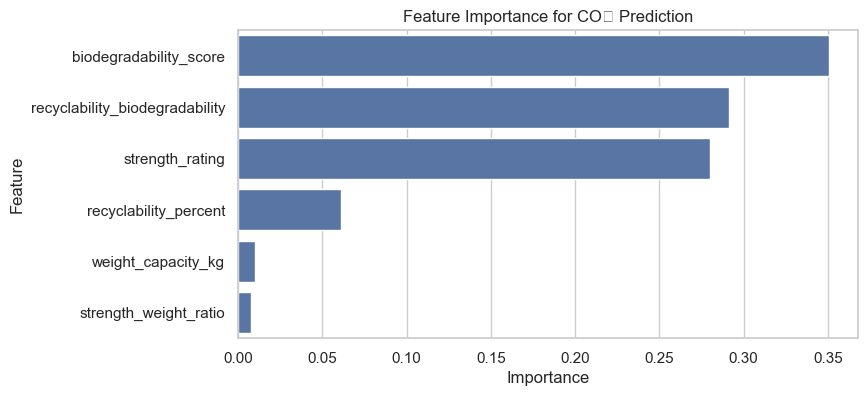

In [22]:
importances = best_xgb.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

display(importance_df)

plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance for CO₂ Prediction")
plt.show()
